In [85]:
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import pandas as pd
import requests

In [86]:
key = os.getenv("EBIRD_API")

# Observations in US (past 7 days)

API [documented here](https://documenter.getpostman.com/view/664302/S1ENwy59#intro)

In [87]:
url = "https://api.ebird.org/v2/data/obs/US/recent"

In [88]:
r = requests.get(url, {"key": key, "back": 7, "includeProvisional": "true"})

In [89]:
data = r.json()

In [90]:
print(f"There were {len(data)} observations reported in the last 7 days.")

There were 752 observations reported in the last 7 days.


# Data Exploration

In [91]:
df = pd.DataFrame.from_records(data)
df.head(5)

,speciesCode,comName,sciName,locId,locName,obsDt,howMany,lat,lng,obsValid,obsReviewed,locationPrivate,subId
0,amekes,American Kestrel,Falco sparverius,L16993375,"2521 East Shawnee Road, Berrien Springs, Michi...",2021-11-28 23:33,1.0,41.943064,-86.397264,True,False,True,S98191822
1,rethaw,Red-tailed Hawk,Buteo jamaicensis,L16993375,"2521 East Shawnee Road, Berrien Springs, Michi...",2021-11-28 23:33,1.0,41.943064,-86.397264,True,False,True,S98191822
2,sancra,Sandhill Crane,Antigone canadensis,L1048333,Rod's Yard,2021-11-28 17:53,80.0,38.382911,-85.962181,True,False,True,S98216447
3,libher,Little Blue Heron,Egretta caerulea,L1023416,Palm Coast Linear Park--St. Joe Walkway,2021-11-28 17:50,1.0,29.559791,-81.194658,True,False,False,S98216451
4,brnpel,Brown Pelican,Pelecanus occidentalis,L1023416,Palm Coast Linear Park--St. Joe Walkway,2021-11-28 17:50,1.0,29.559791,-81.194658,True,False,False,S98216451


There are always privacy considerations when using geographical data. Here, we not only have latitudes and longitudes, but also users' nicknames for those locations. In some cases, those are full addresses. In others, they may leak some personal information (see: `Ron's yard`).

We see this addressed in [their documentation](https://support.ebird.org/en/support/solutions/articles/48000948757-ebird-faqs#anchorhidehome). However, I'd consider the default insecure: "you can rename the location so your address is not visible. You can also place or move the location pin to somewhere close by along your street". It's a hard problem for a scientific project relying on the accuracy of geolocation data, however. Another solution may be to truncate the accuracy of the the coordinates for public API users.

We should also remember that this is self reported data; this always carries certain uncertainty and bias. Are users more likely to record an exotic bird over a common one? Can we trust their `howMany`? Location data is also somewhat self-reported as users can move the pin (at least this restricts us to valid latitude and longitude). By playing with the app, we also know that the actual name information is categorical, not free text.

In [92]:
print(len(df["comName"].unique()) == len(df))

True


Why is every record a unique bird? That seems unlikely. I should review the API documentation. I would expect something like `Red-tailed Hawk` (a relatively common bird) to show up multiple times.

In [93]:
df[df["comName"] == "Red-tailed Hawk"]

,speciesCode,comName,sciName,locId,locName,obsDt,howMany,lat,lng,obsValid,obsReviewed,locationPrivate,subId
1,rethaw,Red-tailed Hawk,Buteo jamaicensis,L16993375,"2521 East Shawnee Road, Berrien Springs, Michi...",2021-11-28 23:33,1.0,41.943064,-86.397264,True,False,True,S98191822


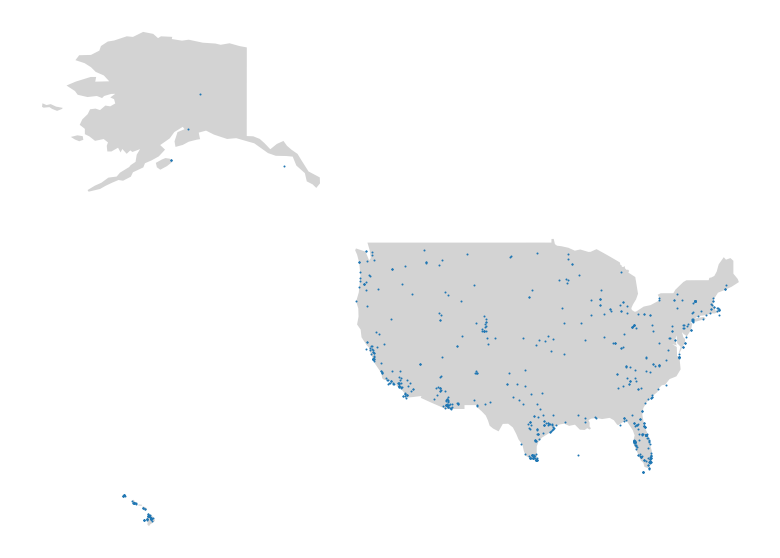

In [95]:
fig, ax = plt.subplots(figsize=(14, 10))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries[countries["iso_a3"] == "USA"].plot(color="lightgrey", ax=ax)
ax.scatter(
    x=df.lng, y=df.lat, s=1
)  # TODO: color by bird-type, but not worthwhile until we have some non-unique birds in the list
ax.axis("off")
plt.show()